In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import datetime as dt
import heapq

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [121]:
# loading data
path = r"Data\AAPL_options.csv"
options_df = pd.read_csv(path)

In [122]:
# creating mid price
options_df.loc[:, "mid price"] = round((options_df["ask price"] + options_df["bid price"])/2, 5)
options_df.head(1)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div,mid price
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377,11.3375


In [123]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call mid"] = 0
options_df["put mid"] = 0
options_df["call_open_interest"] = 0
options_df["put_open_interest"] = 0
options_df["call_volume"] = 0
options_df["put_volume"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
# if call, call mid will be assigned from mid price and put mid will be assigned from next mid price same with open interest
options_df.iloc[indices[call_mask], 16] = options_df.iloc[indices[call_mask], 15].values
options_df.iloc[indices[call_mask], 17] = options_df.iloc[indices[call_mask] + 1, 15].values
# assign values based on put options
options_df.iloc[indices[put_mask], 17] = options_df.iloc[indices[put_mask], 15].values
options_df.iloc[indices[put_mask], 16] = options_df.iloc[indices[put_mask] + 1, 15].values
# open interest
options_df.iloc[indices[call_mask], 18] = options_df.iloc[indices[call_mask], 10].values
options_df.iloc[indices[call_mask], 19] = options_df.iloc[indices[call_mask] + 1, 10].values

options_df.iloc[indices[put_mask], 19] = options_df.iloc[indices[put_mask], 10].values
options_df.iloc[indices[put_mask], 18] = options_df.iloc[indices[put_mask] + 1, 10].values
#volume
options_df.iloc[indices[call_mask], 20] = options_df.iloc[indices[call_mask], 9].values
options_df.iloc[indices[call_mask], 21] = options_df.iloc[indices[call_mask] + 1, 9].values

options_df.iloc[indices[put_mask], 21] = options_df.iloc[indices[put_mask], 9].values
options_df.iloc[indices[put_mask], 20] = options_df.iloc[indices[put_mask] + 1, 9].values

In [124]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

In [125]:
# combining open interest and volume
options_df["combined_oi"] = options_df["call_open_interest"] + options_df["put_open_interest"]
options_df["combined_volume"] = options_df["call_volume"] + options_df["put_volume"]

In [126]:
# dropping unnecessary columns
options_df = options_df.drop(["bid price", "ask price", "last price",
     "exp closing price", "date div", "exp date div", "type", "open interest", "put_volume", "call_volume"], axis=1)

In [127]:
# creating DTE
T = (pd.to_datetime(options_df["expiration date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["DTE"] = T

In [128]:
# dropping rows with zero call and put mid
mask1 = options_df["call mid"] > 0
mask2 = options_df["put mid"] > 0
options_df = options_df[mask1 | mask2]
options_df.head(2)

,date,expiration date,strike price,ask size,bid size,volume,closing price,mid price,call mid,put mid,call_open_interest,put_open_interest,combined_oi,combined_volume,DTE
0,2016-01-04,2016-01-08,15.00,20.0,12.0,0.0,26.337,11.3375,11.3375,0.0025,0,0,0,0,4
1,2016-01-04,2016-01-08,16.25,1412.0,0.0,0.0,26.337,0.0025,10.0875,0.0025,0,0,0,0,4


In [129]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["DTE", "strike price", "closing price", "call mid", "put mid", "call_open_interest", "put_open_interest", "combined_oi", "combined_volume"]:
    df[header] = options_df.groupby("date")[header].apply(np.array)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))
df.head(1)

,date,DTE,strike price,closing price,call mid,put mid,call_open_interest,put_open_interest,combined_oi,combined_volume,terms
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[0, 0, 0, 0, 4, 8, 972, 0, 0, 0, 4, 1260, 48, ...","[0, 0, 0, 0, 2592, 7836, 15908, 3624, 3060, 75...","[0, 0, 0, 0, 2596, 7844, 16880, 3624, 3060, 75...","[0, 0, 0, 0, 4836, 5684, 35092, 1572, 3780, 14...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,..."


In [130]:
#grouping by DTE
def group_by_dte(dte, val, terms):
    grouped_mask = {}
    for i in terms:
        if i not in grouped_mask:
            grouped_mask[i] = []
        grouped_mask[i] = list(np.array(val)[dte == i])

    return list(grouped_mask.values())

df.loc[:, "strikes by DTE"] = [group_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "call_open_interest"] = [group_by_dte(row["DTE"], row["call_open_interest"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "put_open_interest"] = [group_by_dte(row["DTE"], row["put_open_interest"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "combined_oi"] = [group_by_dte(row["DTE"], row["combined_oi"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "combined_volume"] = [group_by_dte(row["DTE"], row["combined_volume"], row["terms"]) for idx, row in df.iterrows()]
df.head(2)

,date,DTE,strike price,closing price,call mid,put mid,call_open_interest,put_open_interest,combined_oi,combined_volume,terms,strikes by DTE
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[[0, 0, 0, 0, 4, 8, 972, 0, 0, 0, 4, 1260, 48,...","[[0, 0, 0, 0, 2592, 7836, 15908, 3624, 3060, 7...","[[0, 0, 0, 0, 2596, 7844, 16880, 3624, 3060, 7...","[[0, 0, 0, 0, 4836, 5684, 35092, 1572, 3780, 1...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5,..."
1,2016-01-05,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 20.125, 20.25...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[10.67875, 9.42875, 8.17875, 6.92875, 5.67875,...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,...","[[0, 0, 0, 0, 5152, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 5156, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...","[3, 10, 17, 24, 31, 38, 45, 73, 101, 164, 192,...","[[15.0, 16.25, 17.5, 18.75, 20.0, 20.125, 20.2..."


In [131]:
#finding max index of open interest and volume
def max_by_dte(row):
    return [np.argmax(x) for x in row]

df.loc[:, "max oi index by DTE"] = list(map(max_by_dte, df.loc[:, "combined_oi"]))
df.loc[:, "max call oi index"] = list(map(max_by_dte, df.loc[:, "call_open_interest"]))
df.loc[:, "max put oi index"] = list(map(max_by_dte, df.loc[:, "put_open_interest"]))
df.loc[:, "max volume index by DTE"] = list(map(max_by_dte, df.loc[:, "combined_volume"]))

In [132]:
# finding strike prices with the greatest volume and open interest for each DTE
def max_of(row, col):
    return [row[i][col[i]] for i in range(len(row))]

df.loc[:, "max oi strikes by DTE"] = list(map(max_of, df["strikes by DTE"], df["max oi index by DTE"]))
df.loc[:, "max call oi strikes"] = list(map(max_of, df["strikes by DTE"], df["max call oi index"]))
df.loc[:, "max put oi strikes"] = list(map(max_of, df["strikes by DTE"], df["max put oi index"]))

df.loc[:, "max oi by DTE"] = list(map(max_of, df["combined_oi"], df["max oi index by DTE"]))
df.loc[:, "max call oi by DTE"] = list(map(max_of, df["call_open_interest"], df["max call oi index"]))
df.loc[:, "max put oi by DTE"] = list(map(max_of, df["put_open_interest"], df["max put oi index"]))

df.loc[:, "max volume strikes by DTE"] = list(map(max_of, df["strikes by DTE"], df["max volume index by DTE"]))
df.loc[:, "max volume by DTE"] = list(map(max_of, df["combined_volume"], df["max volume index by DTE"]))

df.head(1)

,date,DTE,strike price,closing price,call mid,put mid,call_open_interest,put_open_interest,combined_oi,combined_volume,...,max put oi index,max volume index by DTE,max oi strikes by DTE,max call oi strikes,max put oi strikes,max oi by DTE,max call oi by DTE,max put oi by DTE,max volume strikes by DTE,max volume by DTE
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[[0, 0, 0, 0, 4, 8, 972, 0, 0, 0, 4, 1260, 48,...","[[0, 0, 0, 0, 2592, 7836, 15908, 3624, 3060, 7...","[[0, 0, 0, 0, 2596, 7844, 16880, 3624, 3060, 7...","[[0, 0, 0, 0, 4836, 5684, 35092, 1572, 3780, 1...",...,"[16, 82, 7, 11, 15, 0, 11, 12, 12, 12, 11, 12,...","[21, 82, 6, 11, 25, 11, 13, 12, 14, 18, 6, 16,...","[27.5, 30.0, 28.75, 27.5, 27.5, 25.75, 30.0, 2...","[27.5, 30.0, 28.75, 27.5, 27.5, 30.0, 30.0, 30...","[25.0, 27.5, 25.75, 26.25, 26.25, 23.75, 26.25...","[55920, 883732, 29632, 40332, 9608, 556, 24917...","[38744, 622988, 19452, 34928, 9108, 320, 20224...","[27416, 415412, 13780, 21592, 3236, 548, 13537...","[26.25, 27.5, 25.0, 26.25, 28.75, 25.75, 28.75...","[133640, 327096, 19228, 10456, 8992, 8936, 637..."


In [133]:
#reorganizing df
max_df = pd.DataFrame({"date": df["date"],
                       "terms": df["terms"],
                       "close": df["closing price"],
                       "max_volumes": df["max volume by DTE"],
                       "max_ois": df["max oi by DTE"],
                       "max_call_ois": df["max call oi by DTE"],
                       "max_put_ois": df["max put oi by DTE"],
                       "max_volume_strikes": df["max volume strikes by DTE"],
                       "max_oi_strikes": df["max oi strikes by DTE"],
                       "max_call_oi_strikes": df["max call oi strikes"],
                       "max_put_oi_strikes": df["max put oi strikes"]
                       
                      })
max_df.head(1)

,date,terms,close,max_volumes,max_ois,max_call_ois,max_put_ois,max_volume_strikes,max_oi_strikes,max_call_oi_strikes,max_put_oi_strikes
0,2016-01-04,"[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[133640, 327096, 19228, 10456, 8992, 8936, 637...","[55920, 883732, 29632, 40332, 9608, 556, 24917...","[38744, 622988, 19452, 34928, 9108, 320, 20224...","[27416, 415412, 13780, 21592, 3236, 548, 13537...","[26.25, 27.5, 25.0, 26.25, 28.75, 25.75, 28.75...","[27.5, 30.0, 28.75, 27.5, 27.5, 25.75, 30.0, 2...","[27.5, 30.0, 28.75, 27.5, 27.5, 30.0, 30.0, 30...","[25.0, 27.5, 25.75, 26.25, 26.25, 23.75, 26.25..."


In [134]:
#finding which terms have the highest open interest and volume

def high_val_term(row, val):
    maxs_idx = heapq.nlargest(2, range(len(row)), key=row.__getitem__)
    return [val[i] for i in maxs_idx]

max_df["max_oi_term"] = max_df.apply(lambda x: high_val_term(x["max_ois"], x["terms"]), axis=1)
max_df["max_volume_term"] = max_df.apply(lambda x: high_val_term(x["max_volumes"], x["terms"]), axis=1)

max_df["max_oi_strike"] = max_df.apply(lambda x: high_val_term(x["max_ois"], x["max_oi_strikes"]), axis=1)
max_df["max_call_oi_strike"] = max_df.apply(lambda x: high_val_term(x["max_call_ois"], x["max_call_oi_strikes"]), axis=1)
max_df["max_put_oi_strike"] = max_df.apply(lambda x: high_val_term(x["max_put_ois"], x["max_put_oi_strikes"]), axis=1)
max_df["max_volume_strike"] = max_df.apply(lambda x: high_val_term(x["max_volumes"], x["max_volume_strikes"]), axis=1)

max_df.loc[:, "max_oi"] = list(map(lambda x: np.max(x), max_df["max_ois"]))
max_df.loc[:, "max_volume"] = list(map(lambda x: np.max(x), max_df["max_volumes"]))

print(max_df[["max_oi_term", "max_volume_term"]])
print(max_df[["max_oi_strike", "max_volume_strike"]])

    max_oi_term max_volume_term
0     [11, 382]        [46, 11]
1      [10, 45]         [3, 10]
2       [9, 44]          [2, 9]
3       [8, 43]          [1, 8]
4       [7, 42]          [0, 7]
..          ...             ...
247   [28, 392]          [0, 7]
248   [24, 388]         [3, 24]
249   [23, 387]         [2, 23]
250   [22, 386]          [1, 8]
251   [21, 385]         [0, 21]

[252 rows x 2 columns]
     max_oi_strike max_volume_strike
0     [30.0, 25.0]     [28.75, 27.5]
1    [30.0, 28.75]    [26.25, 26.25]
2    [30.0, 28.75]      [25.0, 25.0]
3    [30.0, 28.75]      [25.0, 25.0]
4    [30.0, 28.75]      [24.5, 25.0]
..             ...               ...
247  [28.75, 25.0]      [29.0, 29.0]
248  [28.75, 25.0]      [29.5, 30.0]
249  [28.75, 25.0]      [29.5, 27.5]
250   [27.5, 25.0]    [29.25, 26.25]
251   [27.5, 25.0]     [29.0, 29.25]

[252 rows x 2 columns]


In [135]:
# finding future date where open interest and volume are highest
def fut_date(date, terms):
    return [date + timedelta(int(term)) for term in terms]

max_df.loc[:, "max_oi_dates"] = max_df.apply(lambda x: fut_date(x["date"], x["max_oi_term"]), axis=1)
max_df.loc[:, "max_volume_dates"] = max_df.apply(lambda x: fut_date(x["date"], x["max_volume_term"]), axis=1)

max_df.head(2)

,date,terms,close,max_volumes,max_ois,max_call_ois,max_put_ois,max_volume_strikes,max_oi_strikes,max_call_oi_strikes,...,max_oi_term,max_volume_term,max_oi_strike,max_call_oi_strike,max_put_oi_strike,max_volume_strike,max_oi,max_volume,max_oi_dates,max_volume_dates
0,2016-01-04,"[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[133640, 327096, 19228, 10456, 8992, 8936, 637...","[55920, 883732, 29632, 40332, 9608, 556, 24917...","[38744, 622988, 19452, 34928, 9108, 320, 20224...","[27416, 415412, 13780, 21592, 3236, 548, 13537...","[26.25, 27.5, 25.0, 26.25, 28.75, 25.75, 28.75...","[27.5, 30.0, 28.75, 27.5, 27.5, 25.75, 30.0, 2...","[27.5, 30.0, 28.75, 27.5, 27.5, 30.0, 30.0, 30...",...,"[11, 382]","[46, 11]","[30.0, 25.0]","[30.0, 25.0]","[27.5, 25.0]","[28.75, 27.5]",883732,637636,"[2016-01-15 00:00:00, 2017-01-20 00:00:00]","[2016-02-19 00:00:00, 2016-01-15 00:00:00]"
1,2016-01-05,"[3, 10, 17, 24, 31, 38, 45, 73, 101, 164, 192,...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[141776, 104028, 24428, 9924, 14412, 5464, 434...","[75824, 881440, 30540, 44964, 11628, 5896, 735...","[59132, 620600, 20320, 39544, 11108, 2324, 382...","[47776, 392784, 15440, 21660, 3708, 3572, 3535...","[26.25, 26.25, 25.75, 26.25, 26.25, 25.75, 26....","[27.5, 30.0, 28.75, 27.5, 27.5, 25.75, 28.75, ...","[27.5, 30.0, 28.75, 27.5, 27.5, 25.75, 28.75, ...",...,"[10, 45]","[3, 10]","[30.0, 28.75]","[30.0, 25.0]","[27.5, 28.75]","[26.25, 26.25]",881440,141776,"[2016-01-15 00:00:00, 2016-02-19 00:00:00]","[2016-01-08 00:00:00, 2016-01-15 00:00:00]"


In [158]:
# defining normalization and moving average function
def minmaxnorm(arr, a=0, b=1):
    res = a + (b-a) * (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return res

def ma(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    res = ret / n
    res[:n] = a[:n]
    return res


In [137]:
names = ["oi", "volume"]

def first(iter):
    return [x[0] for x in iter]

def second(iter):
    return [x[1] for x in iter]

def smooth_series(series):
    # initialize the result list with the first element
    smoothed = [series[0][0]] 

    for i in range(1, len(series)):
        prev_value = smoothed[-1] 
        current_list = series[i]

        # check if the first value in the current list matches the previous value
        if current_list[0] == prev_value:
            smoothed.append(current_list[0])
        elif current_list[1] == prev_value:
            smoothed.append(current_list[1])
        else:
            smoothed.append(current_list[0])  

    return smoothed

max_df.loc[:, "smoothed_oi_strike"] = smooth_series(max_df.loc[:, "max_oi_strike"])
max_df.loc[:, "smoothed_volume_strike"] = smooth_series(max_df.loc[:, "max_volume_strike"])
max_df.loc[:, "smoothed_call_oi_strike"] = smooth_series(max_df.loc[:, "max_call_oi_strike"])
max_df.loc[:, "smoothed_put_oi_strike"] = smooth_series(max_df.loc[:, "max_put_oi_strike"])

In [160]:
# dislplaying columns for plotting
for i in range(len(max_df.columns)):
    print(f"{i}:" + max_df.columns[i])

0:date
1:terms
2:close
3:max_volumes
4:max_ois
5:max_call_ois
6:max_put_ois
7:max_volume_strikes
8:max_oi_strikes
9:max_call_oi_strikes
10:max_put_oi_strikes
11:max_oi_term
12:max_volume_term
13:max_oi_strike
14:max_call_oi_strike
15:max_put_oi_strike
16:max_volume_strike
17:max_oi
18:max_volume
19:max_oi_dates
20:max_volume_dates
21:smoothed_oi_strike
22:smoothed_volume_strike
23:smoothed_call_oi_strike
24:smoothed_put_oi_strike


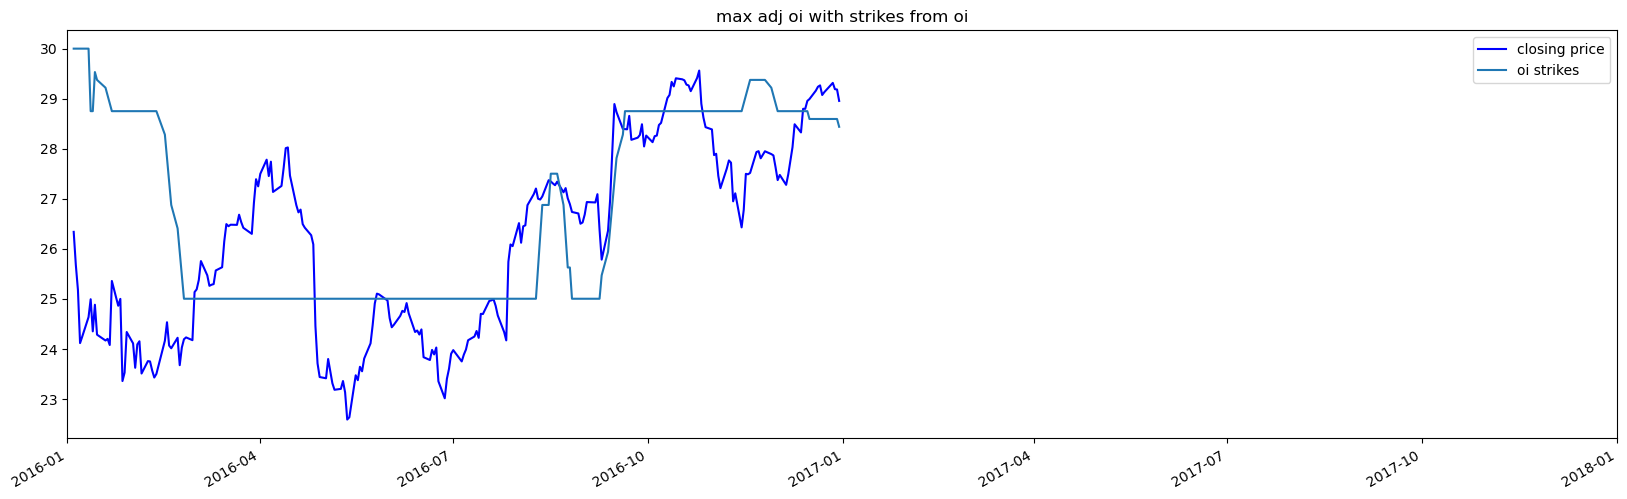

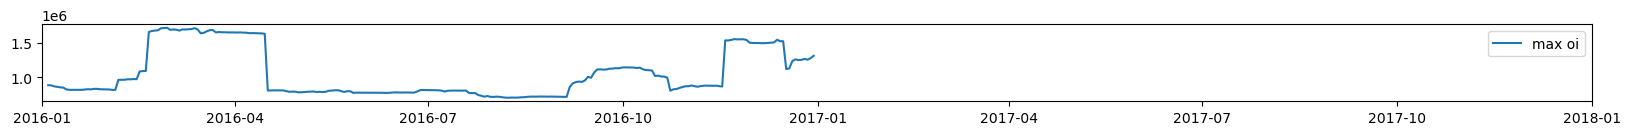

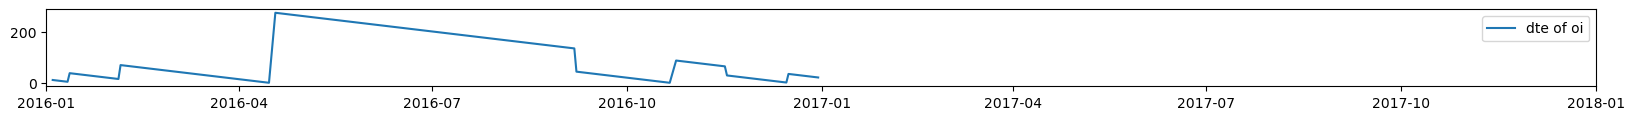

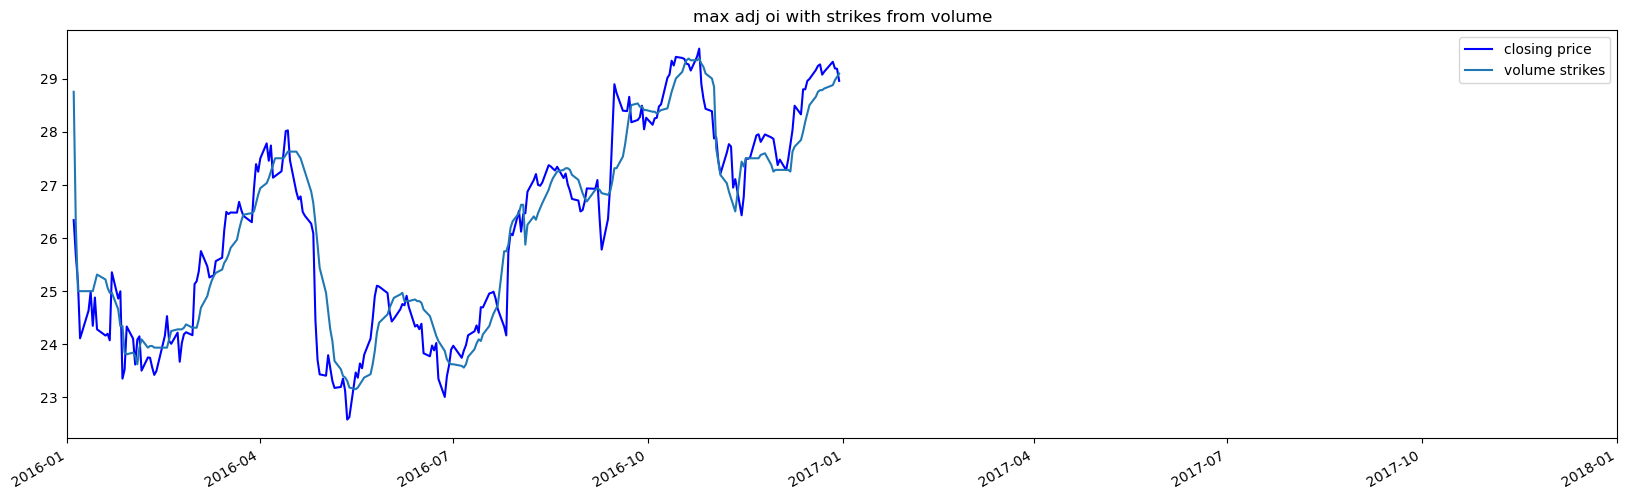

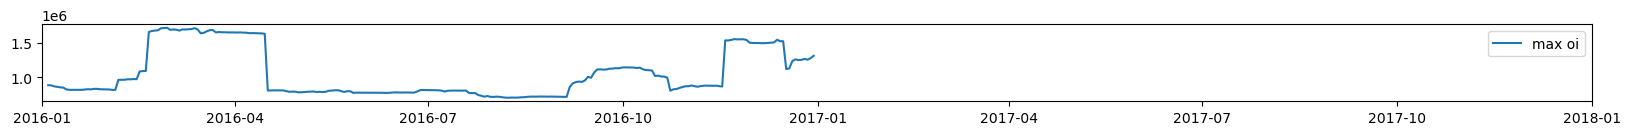

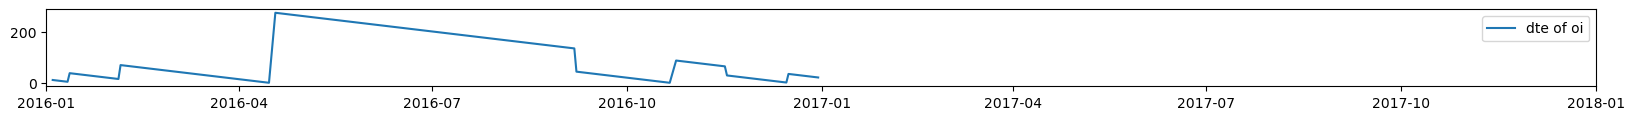

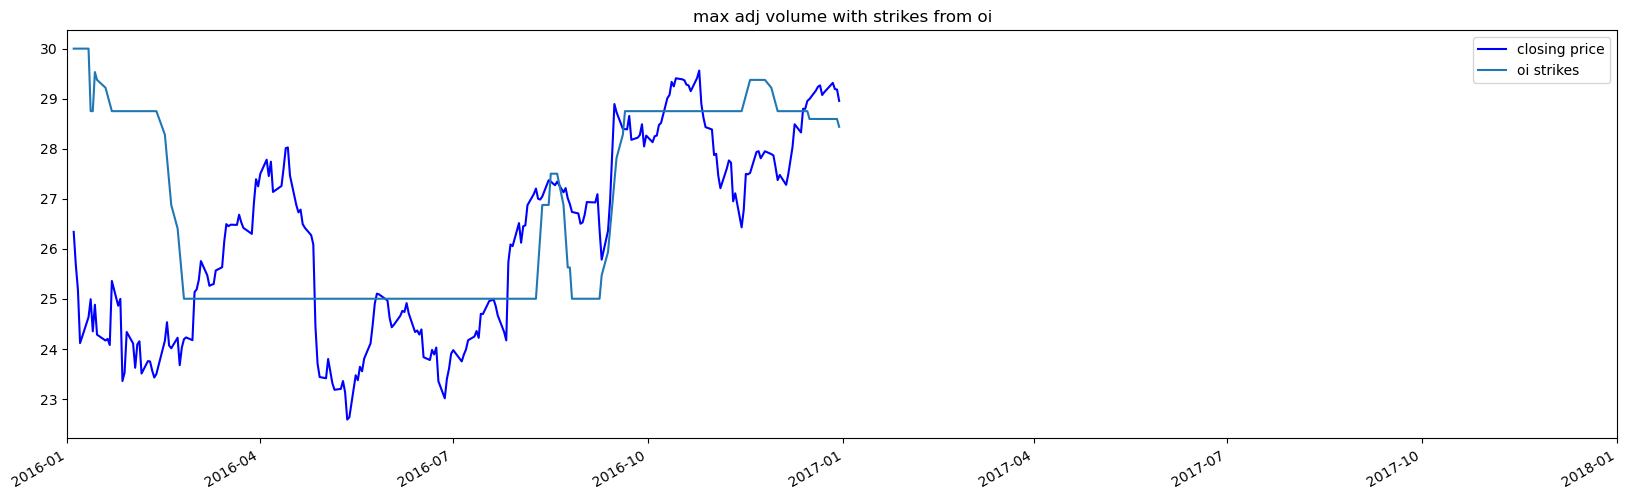

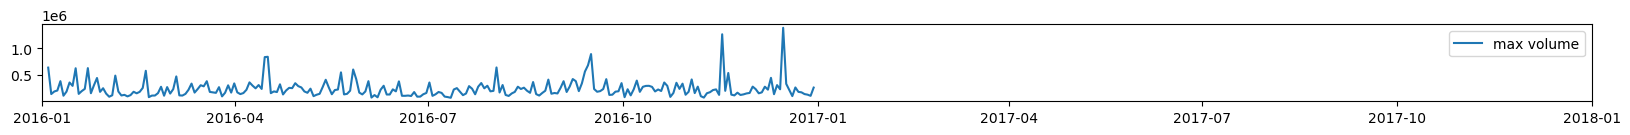

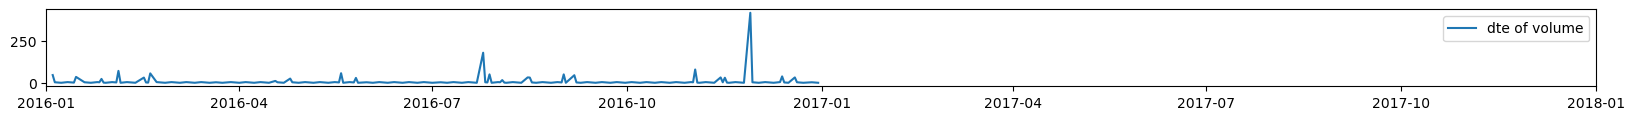

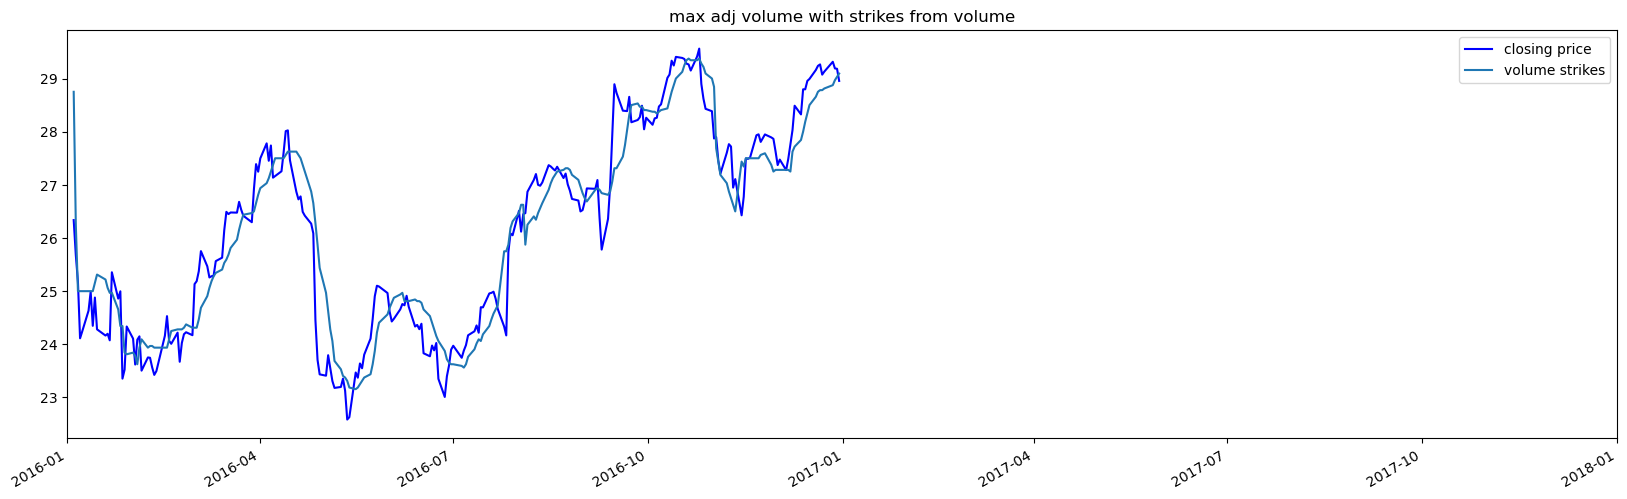

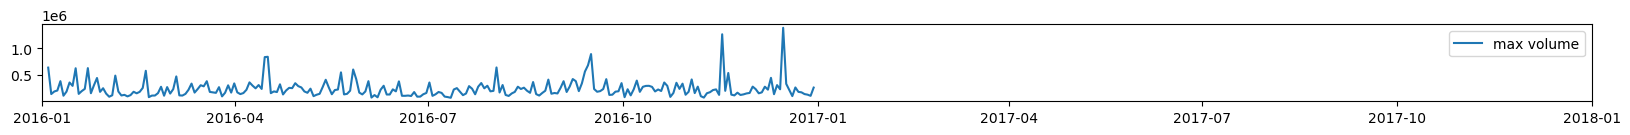

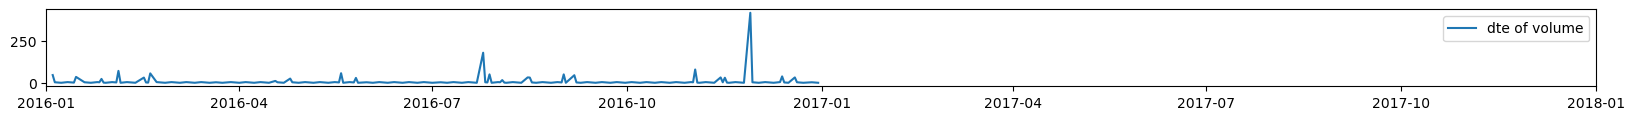

In [161]:
# plotting !!!
for i in range(2):
    for j in range(2):

        min_val = 20
        max_val = 30
      

        #grouped_df = max_df.groupby(pd.Grouper(key='date', freq='3D'))[f"max_{names[i]}"].sum()
        date_range = pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], periods=len(minmaxnorm(max_df[f"max_{names[i]}"], max_val, max_val+5)))


        plt.figure(figsize=(20,6))  
        #closing price
        plt.plot(df["date"], [x[0] for x in df["closing price"]], label="closing price", color="blue")
        l = 21+3j
        #smoothed strike prices
        plt.plot(df["date"],  ma(max_df.iloc[:, 21+j].to_numpy(),8), label=f"{names[j]} strikes")
        plt.xlim([dt.date(2016, 1, 1), dt.date(2018,1,1)])
        plt.title(f"max adj {names[i]} with strikes from {names[j]}")
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.show()

        plt.figure(figsize=(20,1))
        plt.plot(date_range, max_df[f"max_{names[i]}"], label=f"max {names[i]}")
        plt.legend()
        plt.xlim([dt.date(2016, 1, 1), dt.date(2018,1,1)])
        plt.show()

        plt.figure(figsize=(20,1))
        plt.plot(df["date"], [x[0] for x in max_df.iloc[:, 11+i]], label=f"dte of {names[i]}")
        plt.legend()
        plt.xlim([dt.date(2016, 1, 1), dt.date(2018,1,1)])
        plt.show()